# First Model tuning an A into an Ä

In [1]:
# forcing the notebook to reload the modules
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append('../')

In [70]:
import numpy as np
from src.data import datarenderer
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from src.data import fontdb_handler as fh
import datetime
from contextlib import redirect_stdout

In [4]:
# Checking if GPU is available
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


2023-11-25 14:11:48.942283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:11:48.962070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:11:48.962109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


## Creating the Data

In [4]:
trainings_list = []

In [51]:
charset = "AÄ8Bjß"
box_size = 64
num_glyphs = len(charset)
test_size = 0.1
batch_size = 64

In [52]:
PATH_JSON_FONT_DB = '../data/raw/00dataset.json'
font_file_paths = fh.font_file_list(PATH_JSON_FONT_DB) # List with all the paths to the fonts

np.random.seed(42)
font_file_paths = np.random.permutation(font_file_paths)
num_samples = len(font_file_paths)
num_samples

21314

In [11]:
num_test_samples = int(num_samples * test_size)
dataset_train = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[:-num_test_samples], size=box_size, chars=charset, normalize=True).astype(np.float32))
dataset_test = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[-num_test_samples:], size=box_size, chars=charset, normalize=True).astype(np.float32))

2023-11-25 12:48:26.110702: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.
2023-11-25 12:48:26.915132: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.


2023-11-25 12:48:29.829118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.


(64, 64, 6)


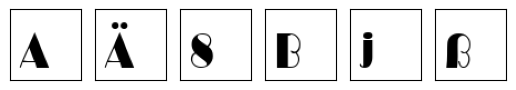

In [12]:
example = next(iter(dataset_train))
print(example.shape)

def render_charset(charset):
    fig, axs = plt.subplots(1, num_glyphs)
    for idx in range(num_glyphs):
        axs[idx].imshow(charset[:, :, idx], cmap="gray")
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
    plt.show()

render_charset(example)

In [13]:
def encode(image):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  return image, image

In [14]:
img1, img2 = encode(example)
print(img1.shape)
print(img2.shape)

(64, 64, 6)
(64, 64, 6)


In [15]:
dataset_train = dataset_train.map(lambda image: encode(image)).shuffle(num_samples - num_test_samples).batch(batch_size)
dataset_test = dataset_test.map(lambda image: encode(image)).batch(batch_size)

In [16]:
def render_predictions(model, dataset_test, num_examples=4, figsize=(10, 10)):
    # function to plot the images: input, target and prediction
    if num_examples < 2:
        raise ValueError("num_examples must be at least 2")
    
    examples = dataset_test.take(num_examples)
    num_glyphs = next(iter(examples))[0].shape[3]

    # print(num_glyphs)

    fig, axs = plt.subplots(num_examples, 3*num_glyphs, figsize=figsize)
    for idx, (input_img, target_img) in enumerate(examples):
        prediction = model.predict(input_img, verbose=0)
        for idx2 in range(num_glyphs):
            axs[idx, 3*idx2].imshow(input_img[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2].set_xticks([])
            axs[idx, 3*idx2].set_yticks([])
            axs[idx, 3*idx2].set_title("Input")
            axs[idx, 3*idx2+1].imshow(target_img[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2+1].set_xticks([])
            axs[idx, 3*idx2+1].set_yticks([])
            axs[idx, 3*idx2+1].set_title("Target")
            axs[idx, 3*idx2+2].imshow(prediction[0, :, :, idx2], cmap="gray")
            axs[idx, 3*idx2+2].set_xticks([])
            axs[idx, 3*idx2+2].set_yticks([])
            axs[idx, 3*idx2+2].set_title("Prediction")
    plt.show()

In [17]:
def render_histories(trainings_list):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for idx, training in enumerate(trainings_list):
        axs[0].plot(training["history"].history["loss"], label=f"Training {idx}")
        axs[1].plot(training["history"].history["val_loss"], label=f"Training {idx}")
    axs[0].set_title("Training loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[1].set_title("Validation loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend()
    plt.show()

def analyze_trainings(trainings_list):
    metric_compare = "val_loss"
    if len(trainings_list) < 2:
        idx_best_training = 0
    else:
        idx_best_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list])
        # if this was also the last training
        if idx_best_training == len(trainings_list) - 1:
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            # getting the index of the second best training
            idx_compare_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list[:-1]])
        else:
            idx_compare_training = len(trainings_list) - 1

    print(f"\nThe summary of the model with the best {metric_compare} during training:")
    print(trainings_list[idx_best_training]["history"].model.summary())
    print("\nThe other parameters of the best training:")
    for key, value in trainings_list[idx_best_training].items():
        if key != "history":
            print(f"{key}: {value}")
    # plotting the training and validation loss of the best training and the training to compare
    if "idx_compare_training" in locals():
        render_histories([trainings_list[idx_best_training], trainings_list[idx_compare_training]])
    else:
        render_histories([trainings_list[idx_best_training]])

In [18]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    # Encoder
    self.encoder_reshape = layers.Reshape((box_size*box_size*num_glyphs,))
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_fc2 = layers.Dense(box_size*box_size*num_glyphs, activation="sigmoid")
    self.decoder_reshape = layers.Reshape((box_size, box_size, num_glyphs))

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, num_glyphs)
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.encoder_reshape(x)
    encoded = self.encoder_fc1(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, z):
    decoded = self.decoder_fc1(z)
    decoded = self.decoder_fc2(decoded)
    decoded = self.decoder_reshape(decoded)
    return decoded

model = AutoEncoder(128)

model.summary()
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy"
)

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 512)               12583424  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 24576)             12607488  
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 6)         0         
                                                                 
Total params: 25322624 (96.60 MB)
Trainable params: 25

In [19]:
trainings_list.append({
    "charset": charset,
    "box_size": box_size,
    "test_size": test_size,
    "batch_size": batch_size,
    "history": model.fit(
        dataset_train,
        epochs=10,
        validation_data=dataset_test
)})

2023-11-25 12:48:31.011323: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1885765632 exceeds 10% of free system memory.


Epoch 1/10


2023-11-25 12:48:32.597430: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-25 12:48:34.030730: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc23c9a9b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 12:48:34.030778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-11-25 12:48:34.037619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 12:48:34.060741: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-25 12:48:34.132577: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 [==============================] - 8s 15ms/step - loss: 0.1296 - val_loss: 0.1063
Epoch 2/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0979 - val_loss: 0.0940
Epoch 3/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0889 - val_loss: 0.0880
Epoch 4/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0835 - val_loss: 0.0837
Epoch 5/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0795 - val_loss: 0.0809
Epoch 6/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0767 - val_loss: 0.0785
Epoch 7/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0743 - val_loss: 0.0773
Epoch 8/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0725 - val_loss: 0.0756
Epoch 9/10
300/300 [==============================] - 5s 14ms/step - loss: 0.0710 - val_loss: 0.0752
Epoch 10/10
300/300 [==============================] - 4s 13ms/step - loss: 0.0697 - val_loss: 0.0753



The summary of the model with the best val_loss during training:
Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 24576)             0         
                                                                 
 dense (Dense)               (None, 512)               12583424  
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 24576)             12607488  
                                                                 
 reshape_1 (Reshape)         (None, 64, 64, 6)         0         
                                                      

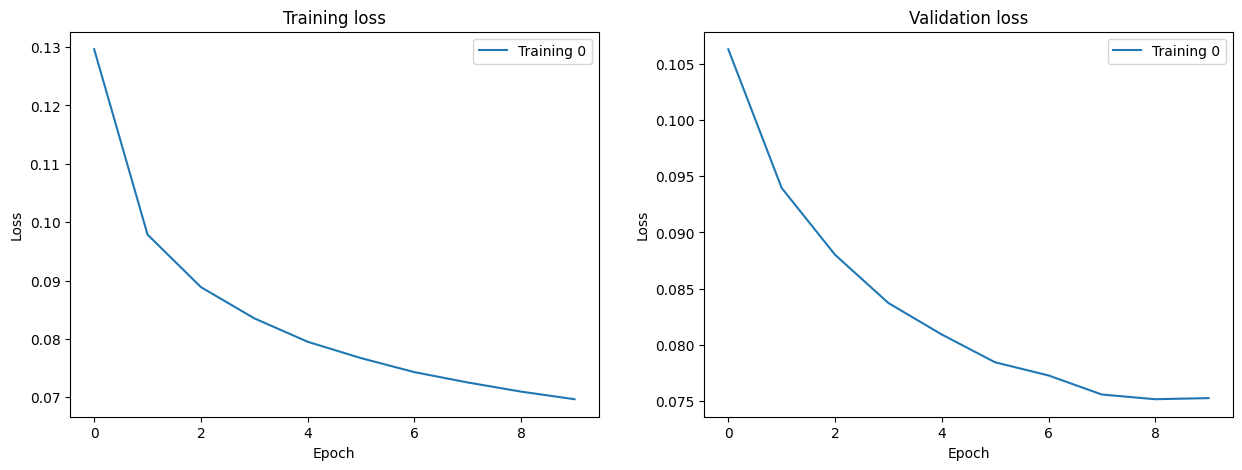

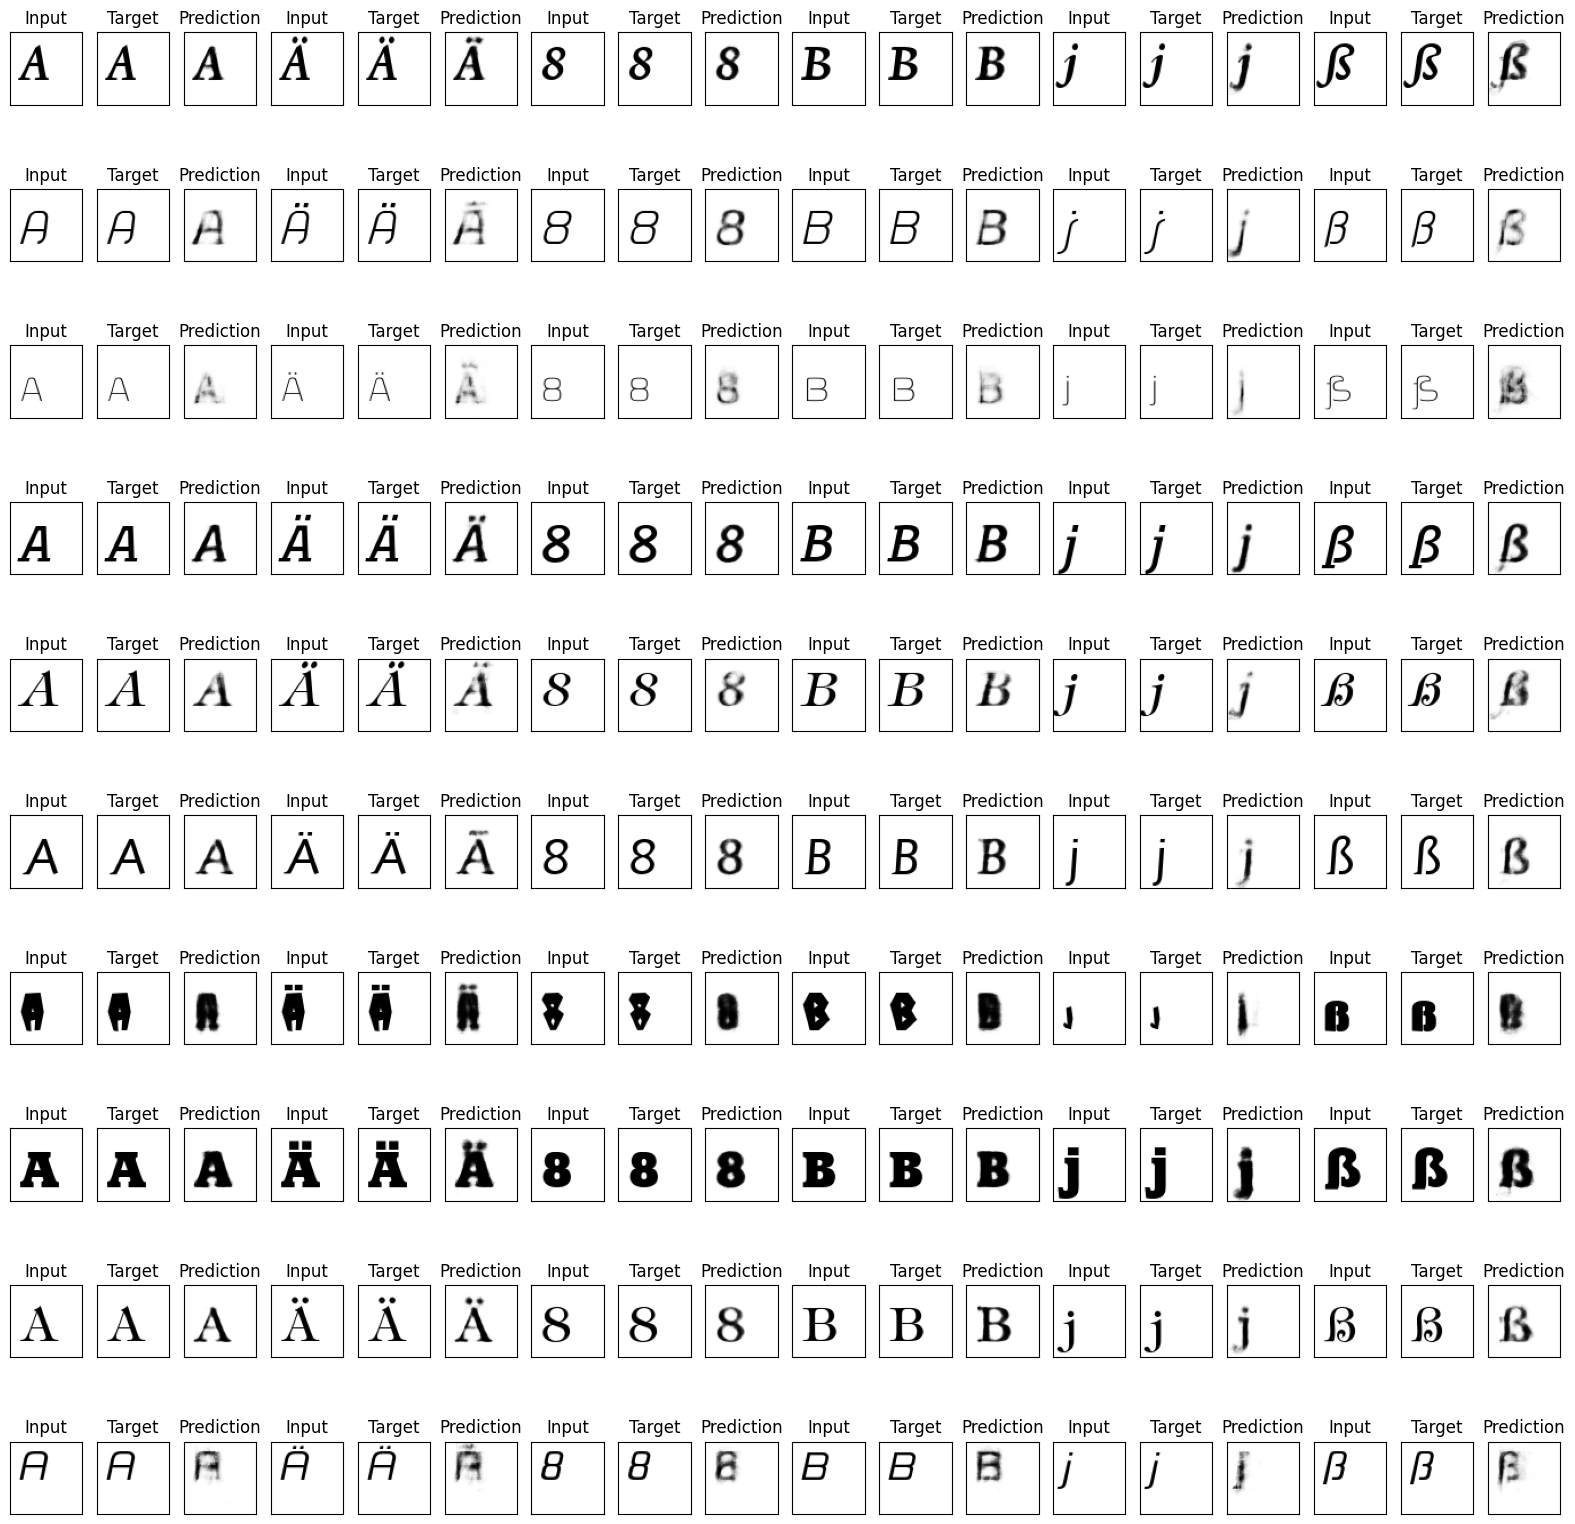

In [20]:
analyze_trainings(trainings_list)
render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20))

# Model with different input and output

## Defenitions

In [5]:
if "trainings_list" not in locals():
    trainings_list = []

In [6]:
charset_in = "AaOoUu8Bj"
charset_out = "ÄäÖöÜüß"
box_size = 64
#num_glyphs = len(charset)
test_size = 0.1
batch_size = 32

In [7]:
PATH_JSON_FONT_DB = '../data/raw/00dataset.json'
font_file_paths = fh.font_file_list(PATH_JSON_FONT_DB) # List with all the paths to the fonts

np.random.seed(42)
font_file_paths = font_file_paths#[:100]
font_file_paths = np.random.permutation(font_file_paths)
num_samples = len(font_file_paths)
num_samples

21314

## Creating the Data

In [8]:
num_test_samples = int(num_samples * test_size)
len_charset_in = len(charset_in)
len_charset_out = len(charset_out)
dataset_train = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[:-num_test_samples], 
                                                                     size=box_size, 
                                                                     chars=charset_in + charset_out, 
                                                                     normalize=True))
dataset_test = Dataset.from_tensor_slices(datarenderer.render_fonts(font_file_paths[-num_test_samples:], 
                                                                    size=box_size, 
                                                                    chars=charset_in + charset_out, 
                                                                    normalize=True))


2023-11-25 14:12:57.351833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:12:57.351927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:12:57.351953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:12:57.698571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-25 14:12:57.698626: I tensorflow/compile

2023-11-25 14:13:06.151512: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2514354176 exceeds 10% of free system memory.


(64, 64, 16)


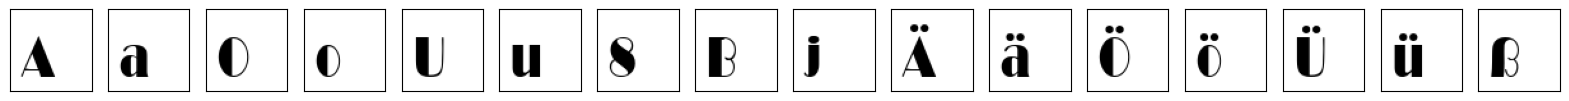

In [9]:
example = next(iter(dataset_train))
print(example.shape)

def render_charset(charset):
    fig, axs = plt.subplots(1, len(charset_in + charset_out), figsize=(20, 20))
    for idx in range(len(charset_in + charset_out)):
        axs[idx].imshow(charset[:, :, idx], cmap="gray")
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
    plt.show()

render_charset(example)

In [10]:
dataset_train = dataset_train.map(lambda image: (image[:,:,:len(charset_in)], image[:,:,len(charset_in):])).shuffle(num_samples - num_test_samples).batch(batch_size)
dataset_test = dataset_test.map(lambda image: (image[:,:,:len(charset_in)], image[:,:,len(charset_in):])).batch(batch_size)

## Helper Functions

In [75]:
def render_predictions(model, dataset_test, num_examples=4, figsize=(10, 10), black_white=False, show_plot=True):
    # function to plot the images: input, target and prediction
    if num_examples < 2:
        raise ValueError("num_examples must be at least 2")
    
    x_val, y_val = next(iter(dataset_test))
    
    num_glyphs_x = x_val.shape[3]
    num_glyphs_y = y_val.shape[3]

    fig, axs = plt.subplots(num_examples, 
                            num_glyphs_x + num_glyphs_y*2, 
                            figsize=figsize)
    for idx in range(num_examples):
        input_img = x_val[idx, :, :, :]
        target_img = y_val[idx, :, :, :]
        prediction = model.predict(input_img[np.newaxis, :, :, :], verbose=0)
        if black_white:
            #prediction = np.where(prediction > 0.4, 1, 0)
            # increasing the contrast of the prediction with a fermi-dirac function
            temp = 0.05
            prediction = 1 / (1 + np.exp(-(prediction - 0.5)/temp))
        for idx2 in range(num_glyphs_x):
            axs[idx, idx2].imshow(input_img[:, :, idx2], cmap="gray")
            axs[idx, idx2].set_xticks([])
            axs[idx, idx2].set_yticks([])
            axs[idx, idx2].set_title("Input")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + idx2].imshow(target_img[:, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + idx2].set_xticks([])
            axs[idx, num_glyphs_x + idx2].set_yticks([])
            axs[idx, num_glyphs_x + idx2].set_title("Target")
        for idx2 in range(num_glyphs_y):
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].imshow(prediction[0, :, :, idx2], cmap="gray")
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_xticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_yticks([])
            axs[idx, num_glyphs_x + num_glyphs_y + idx2].set_title("Prediction")
    if show_plot:
        plt.show()
    else:
        return fig, axs

def render_histories(trainings_list, show_plot=True):
    if len(trainings_list) > 1:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for idx, training in enumerate(trainings_list):
            axs[0].plot(training["history"].history["loss"], label=f"Training {idx}")
            axs[1].plot(training["history"].history["val_loss"], label=f"Training {idx}")
        axs[0].set_title("Training loss")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[1].set_title("Validation loss")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
    else:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
        axs.plot(trainings_list[0]["history"].history["loss"], label=f"Training Loss")
        axs.plot(trainings_list[0]["history"].history["val_loss"], label=f"Validation Loss")
        axs.set_title("Training and validation loss")
        axs.set_xlabel("Epoch")
        axs.set_ylabel("Loss")
        axs.legend()

    if show_plot:
        plt.show()
    else:
        return fig, axs

def analyze_trainings(trainings_list):
    metric_compare = "val_loss"
    if len(trainings_list) < 2:
        idx_best_training = 0
    else:
        idx_best_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list])
        # if this was also the last training
        if idx_best_training == len(trainings_list) - 1:
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            print("Best training was the last one!")
            print("###############################")
            # getting the index of the second best training
            idx_compare_training = np.argmin([np.min(training["history"].history[metric_compare]) for training in trainings_list[:-1]])
        else:
            idx_compare_training = len(trainings_list) - 1

    print(f"\nThe summary of the model with the best {metric_compare} during training:")
    print(trainings_list[idx_best_training]["history"].model.summary())
    print("\nThe other parameters of the best training:")
    for key, value in trainings_list[idx_best_training].items():
        if key != "history":
            print(f"{key}: {value}")
    # plotting the training and validation loss of the best training and the training to compare
    if "idx_compare_training" in locals():
        render_histories([trainings_list[idx_best_training], trainings_list[idx_compare_training]])
    else:
        render_histories([trainings_list[idx_best_training]])

def save_summary_last_training(trainings_list, save_path_summary, save_path_model=None):
    """
    Saves a collection of possible important information about the last training.
    * the model summary
    * the keys and values of the trainings_list (except the history)
    * the plot of the training and validation loss
    * the plot of 10 validation examples with input, target and prediction

    Args:
        trainings_list (list): list of dictionaries with the trainings
    """
    
    # Prefix for the file names will be the date and time in the format YYYYMMDD_HHMMSS
    prefix = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # and addionally the best validation loss and training loss during the last training
    prefix += f"_val_loss_{np.min(trainings_list[-1]['history'].history['val_loss']):.4f}_train_loss_{np.min(trainings_list[-1]['history'].history['loss']):.4f}"
    
    if not os.path.exists(save_path_summary):
        os.makedirs(save_path_summary)

    # Saving the model summary and the other parameters of the last training
    with open(os.path.join(save_path_summary, f"{prefix}_summary.txt"), "a") as f:
        with redirect_stdout(f):
            trainings_list[-1]["history"].model.summary()
        f.write("\n")
        for key, value in trainings_list[-1].items():
            if key != "history":
                f.write(f"{key}: {value}\n")
        # addionally the lists of the training and validation loss
        f.write(f"training_loss: {trainings_list[-1]['history'].history['loss']}\n")
        f.write(f"validation_loss: {trainings_list[-1]['history'].history['val_loss']}\n")

    # Saving the plot of the training and validation loss
    fig, axs = render_histories([trainings_list[-1]], show_plot=False)
    fig.savefig(os.path.join(save_path_summary, f"{prefix}_loss.png"), dpi=300)

    # Saving the plot of 10 validation examples with input, target and prediction
    fig, axs = render_predictions(trainings_list[-1]["history"].model, dataset_test, num_examples=10, figsize=(20, 20), show_plot=False)
    fig.savefig(os.path.join(save_path_summary, f"{prefix}_predictions.png"), dpi=300)
    fig, axs = render_predictions(trainings_list[-1]["history"].model, dataset_test, num_examples=10, figsize=(20, 20), black_white=True, show_plot=False)
    fig.savefig(os.path.join(save_path_summary, f"{prefix}_predictions_black_white.png"), dpi=300)

    if save_path_model is not None:
        if not os.path.exists(save_path_model):
            os.makedirs(save_path_model)
        trainings_list[-1]["history"].model.save(os.path.join(save_path_model, f"{prefix}_model.keras"))

## Creating the Model

In [94]:
class AutoEncoder(tf.keras.Model):

  def __init__(self, latent_dim, *args, **kwargs):
    assert isinstance(latent_dim, int)
    super().__init__(*args, **kwargs)
    self.latent_dim = latent_dim

    self.inverter_layer = lambda x: 1 - x

    # Encoder
    self.encoder_conv2d_1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_1 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_conv2d_2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_2 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_dropout_1 = layers.Dropout(0.1)
    self.encoder_conv2d_3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")
    self.encoder_maxpool_3 = layers.MaxPooling2D((2, 2), padding="same")
    self.encoder_flatten = layers.Flatten()
    self.encoder_dropout_2 = layers.Dropout(0.1)
    self.encoder_fc1 = layers.Dense(512, activation="relu")
    self.encoder_dropout_3 = layers.Dropout(0.1)
    self.encoder_fc2 = layers.Dense(latent_dim, activation="relu")

    # TODO: Decoder
    self.decoder_dropout_1 = layers.Dropout(0.1)
    self.decoder_fc1 = layers.Dense(512, activation="relu")
    self.decoder_reshape = layers.Reshape((4, 4, 32))
    self.decoder_upsample_1 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_1 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")
    self.decoder_dropout_2 = layers.Dropout(0.1)
    self.decoder_upsample_2 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")
    self.decoder_dropout_3 = layers.Dropout(0.1)
    self.decoder_upsample_3 = layers.UpSampling2D((2, 2))
    self.decoder_conv2d_3 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")
    self.decoder_out = layers.Conv2DTranspose(len(charset_out), (3, 3), strides=(2, 2), padding="same")

    self._build_graph()

  def _build_graph(self): # Just here because we want to see the output shapes in the summary.
    input_shape = (box_size, box_size, len(charset_in))
    self.build( (None,) + input_shape ) # (None, 28, 28, 1)
    inputs = tf.keras.Input(shape=input_shape)
    _ = self.call(inputs)

  def call(self, x):
    z = self.encode(x)
    y = self.decode(z)
    return y

  def encode(self, x):
    encoded = self.inverter_layer(x)
    encoded = self.encoder_conv2d_1(encoded)
    encoded = self.encoder_maxpool_1(encoded)
    encoded = self.encoder_conv2d_2(encoded)
    encoded = self.encoder_maxpool_2(encoded)
    #encoded = self.encoder_dropout_1(encoded)
    encoded = self.encoder_conv2d_3(encoded)
    encoded = self.encoder_maxpool_3(encoded)
    encoded = self.encoder_flatten(encoded)
    #encoded = self.encoder_dropout_2(encoded)
    encoded = self.encoder_fc1(encoded)
    #encoded = self.encoder_dropout_3(encoded)
    encoded = self.encoder_fc2(encoded)
    return encoded

  def decode(self, decoded):
    #decoded = self.decoder_dropout_1(decoded)
    decoded = self.decoder_fc1(decoded)
    decoded = self.decoder_reshape(decoded)
    decoded = self.decoder_upsample_1(decoded)
    decoded = self.decoder_conv2d_1(decoded)
    #decoded = self.decoder_dropout_2(decoded)
    decoded = self.decoder_upsample_2(decoded)
    decoded = self.decoder_conv2d_2(decoded)
    #decoded = self.decoder_dropout_3(decoded)
    decoded = self.decoder_upsample_3(decoded)
    decoded = self.decoder_conv2d_3(decoded)
    decoded = self.decoder_out(decoded)
    decoded = self.inverter_layer(decoded)
    return decoded


In [95]:
model = AutoEncoder(128)

model.compile(
    optimizer = "adam",
    loss = "mse"
)

model.summary()

Model: "auto_encoder_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        2624      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_35 (Dropout)        multiple                  0 (unused)
                                                                 
 conv2d_50 (Conv2D)          (None, 16, 16, 128)    

## Training the Model

In [96]:
trainings_list.append({
    "charset_in": charset_in,
    "charset_out": charset_out,
    "box_size": box_size,
    "test_size": test_size,
    "batch_size": batch_size,
    "history": model.fit(
        dataset_train,
        epochs=50,
        validation_data=dataset_test
)})

Epoch 1/50


600/600 [==============================] - 12s 16ms/step - loss: 0.0321 - val_loss: 0.0268
Epoch 2/50
600/600 [==============================] - 11s 15ms/step - loss: 0.0245 - val_loss: 0.0236
Epoch 3/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0223 - val_loss: 0.0222
Epoch 4/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0210 - val_loss: 0.0214
Epoch 5/50
600/600 [==============================] - 9s 14ms/step - loss: 0.0201 - val_loss: 0.0205
Epoch 6/50
600/600 [==============================] - 9s 14ms/step - loss: 0.0195 - val_loss: 0.0205
Epoch 7/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0191 - val_loss: 0.0197
Epoch 8/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0186 - val_loss: 0.0195
Epoch 9/50
600/600 [==============================] - 10s 15ms/step - loss: 0.0182 - val_loss: 0.0195
Epoch 10/50
600/600 [==============================] - 9s 15ms/step - loss: 0.0179 - val_loss: 

## Analyzing the Model

### On the Validation Set

###############################
Best training was the last one!
###############################
Best training was the last one!
###############################
Best training was the last one!
###############################

The summary of the model with the best val_loss during training:
Model: "auto_encoder_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 64, 64, 32)        2624      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                    

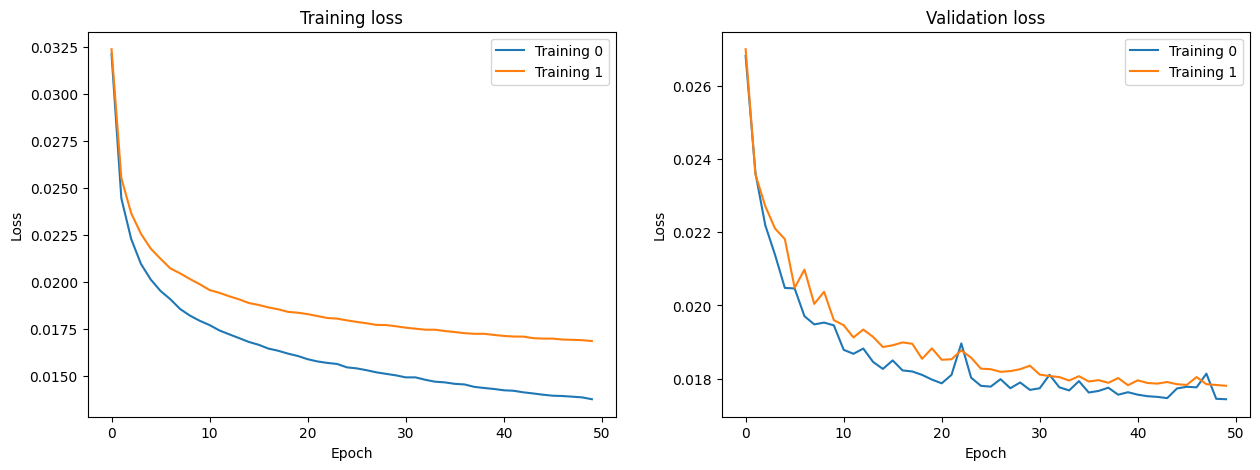

In [97]:
analyze_trainings(trainings_list)
#render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20))
#render_predictions(model, dataset_test, num_examples=10, figsize=(20, 20), black_white=True)

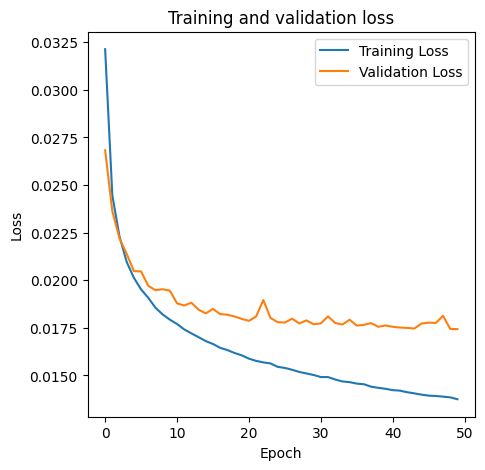

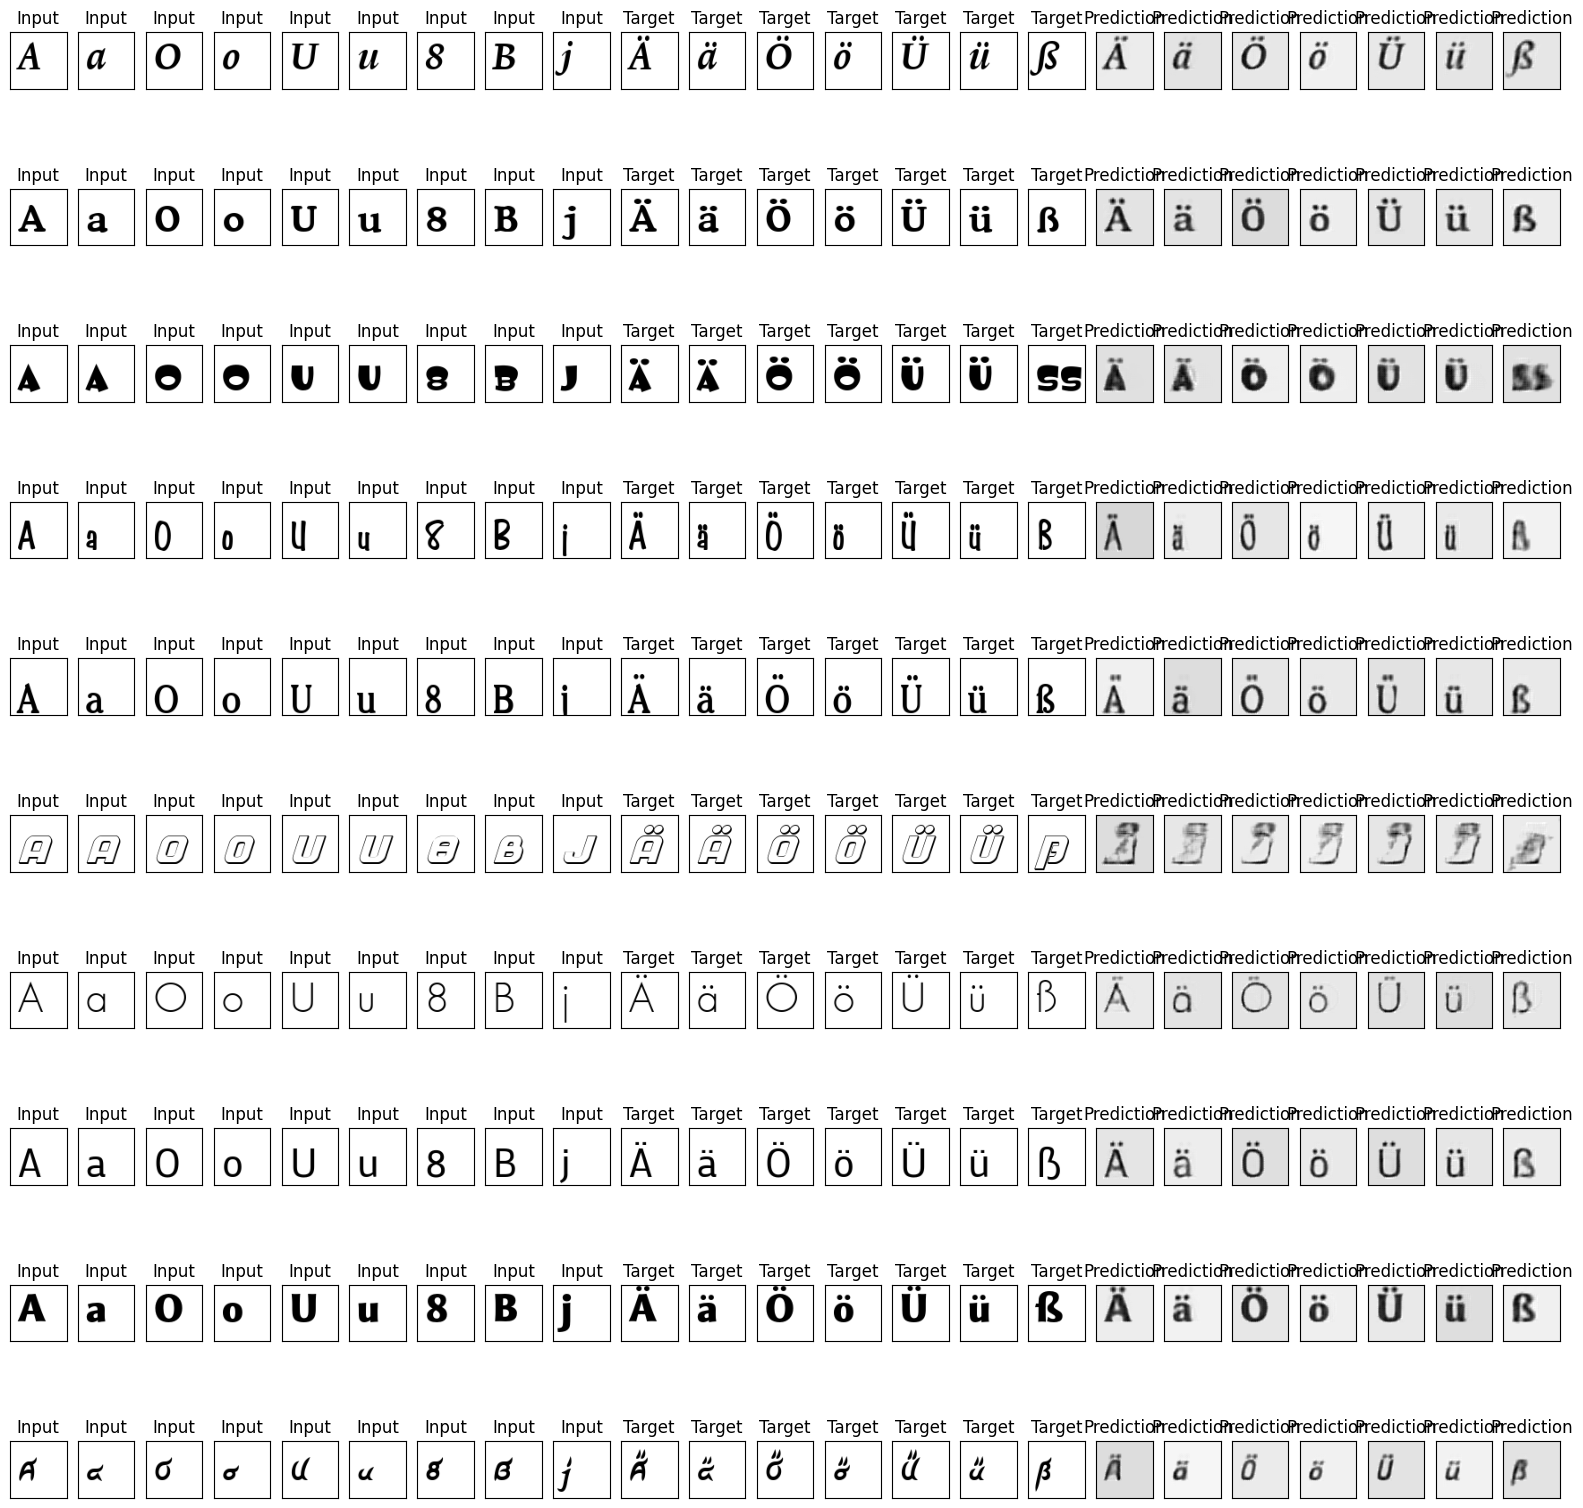

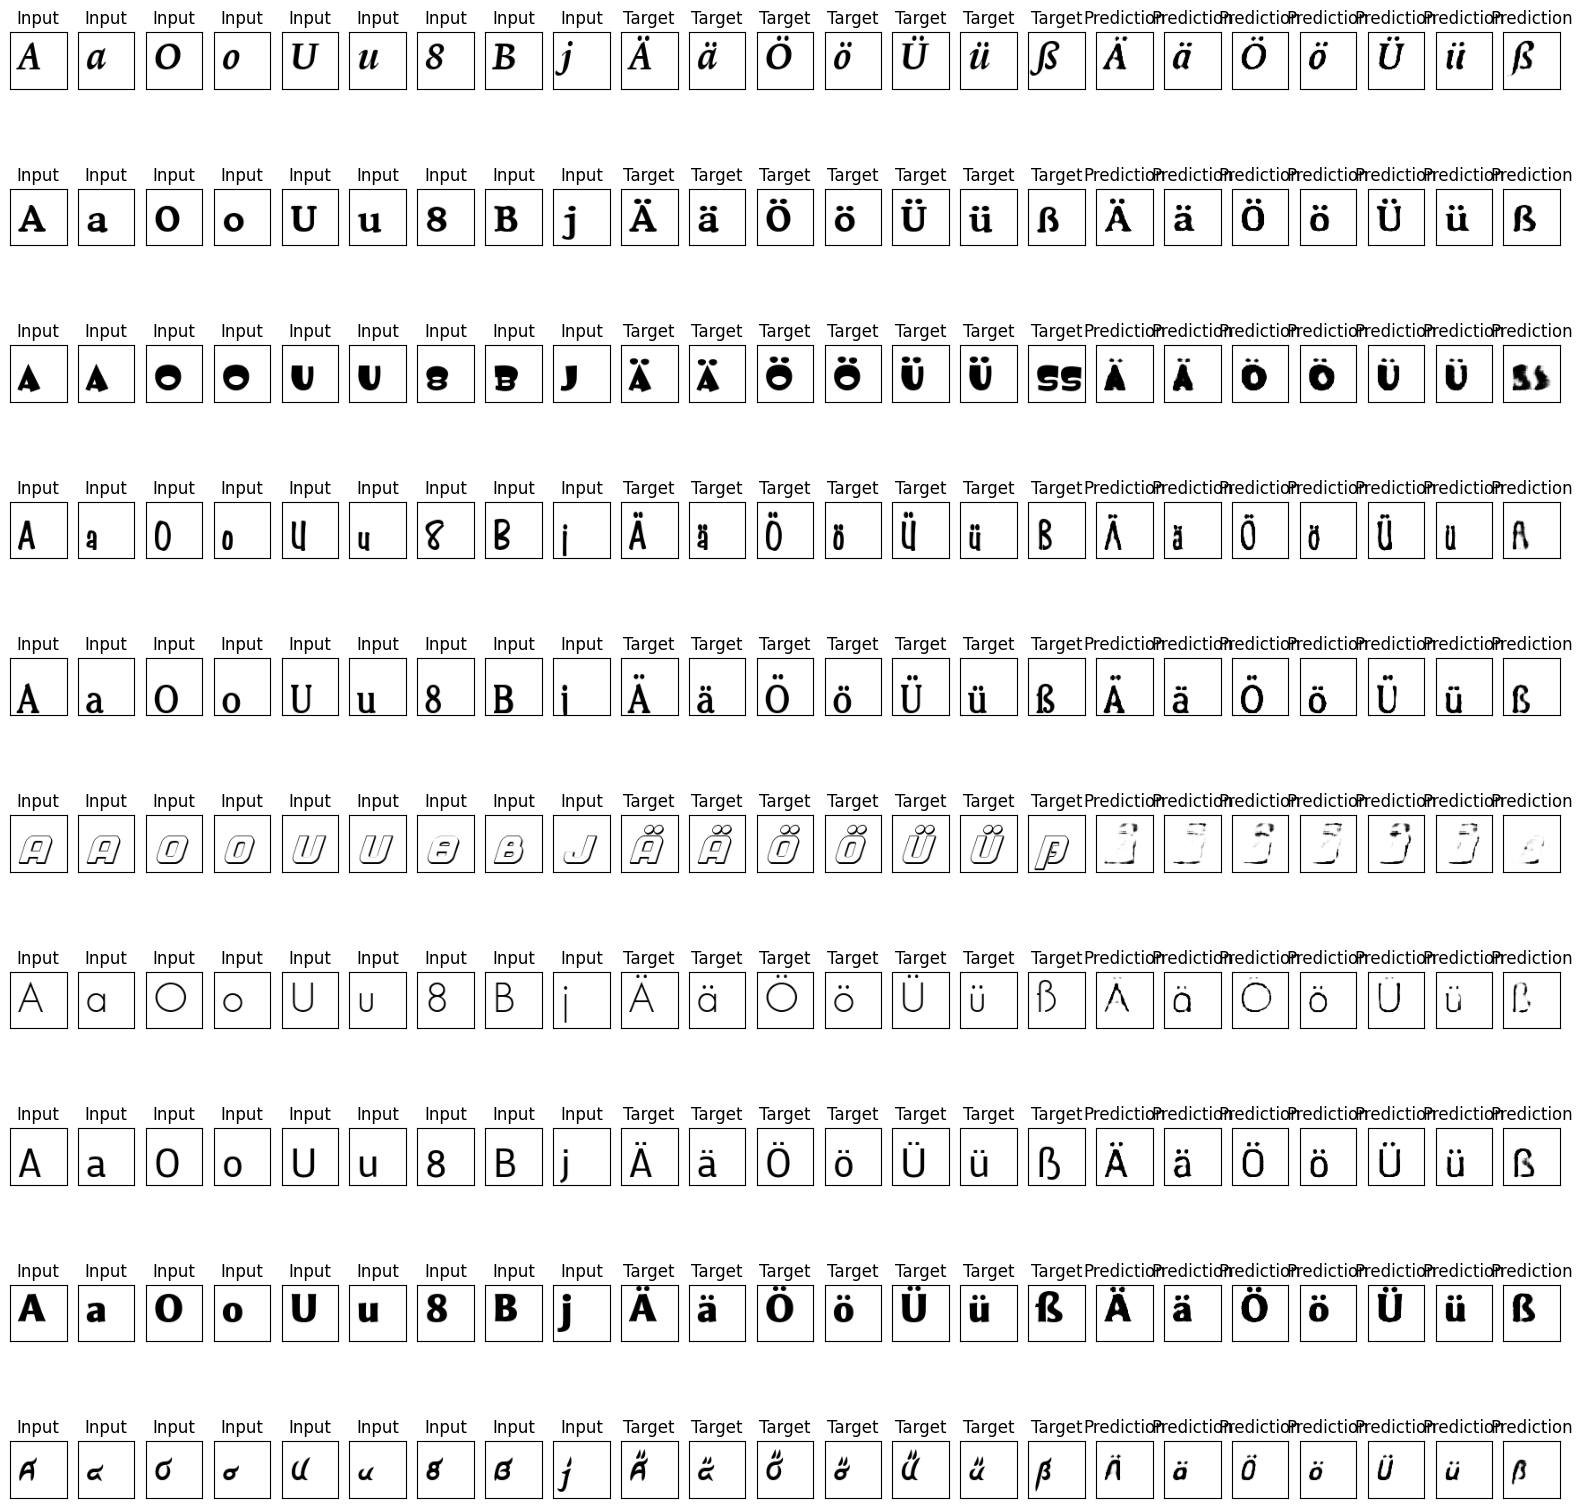

In [98]:
save_summary_last_training(
                           trainings_list, 
                           "../models/logs/", 
                           "../models/"
                           )

### On the Training Set

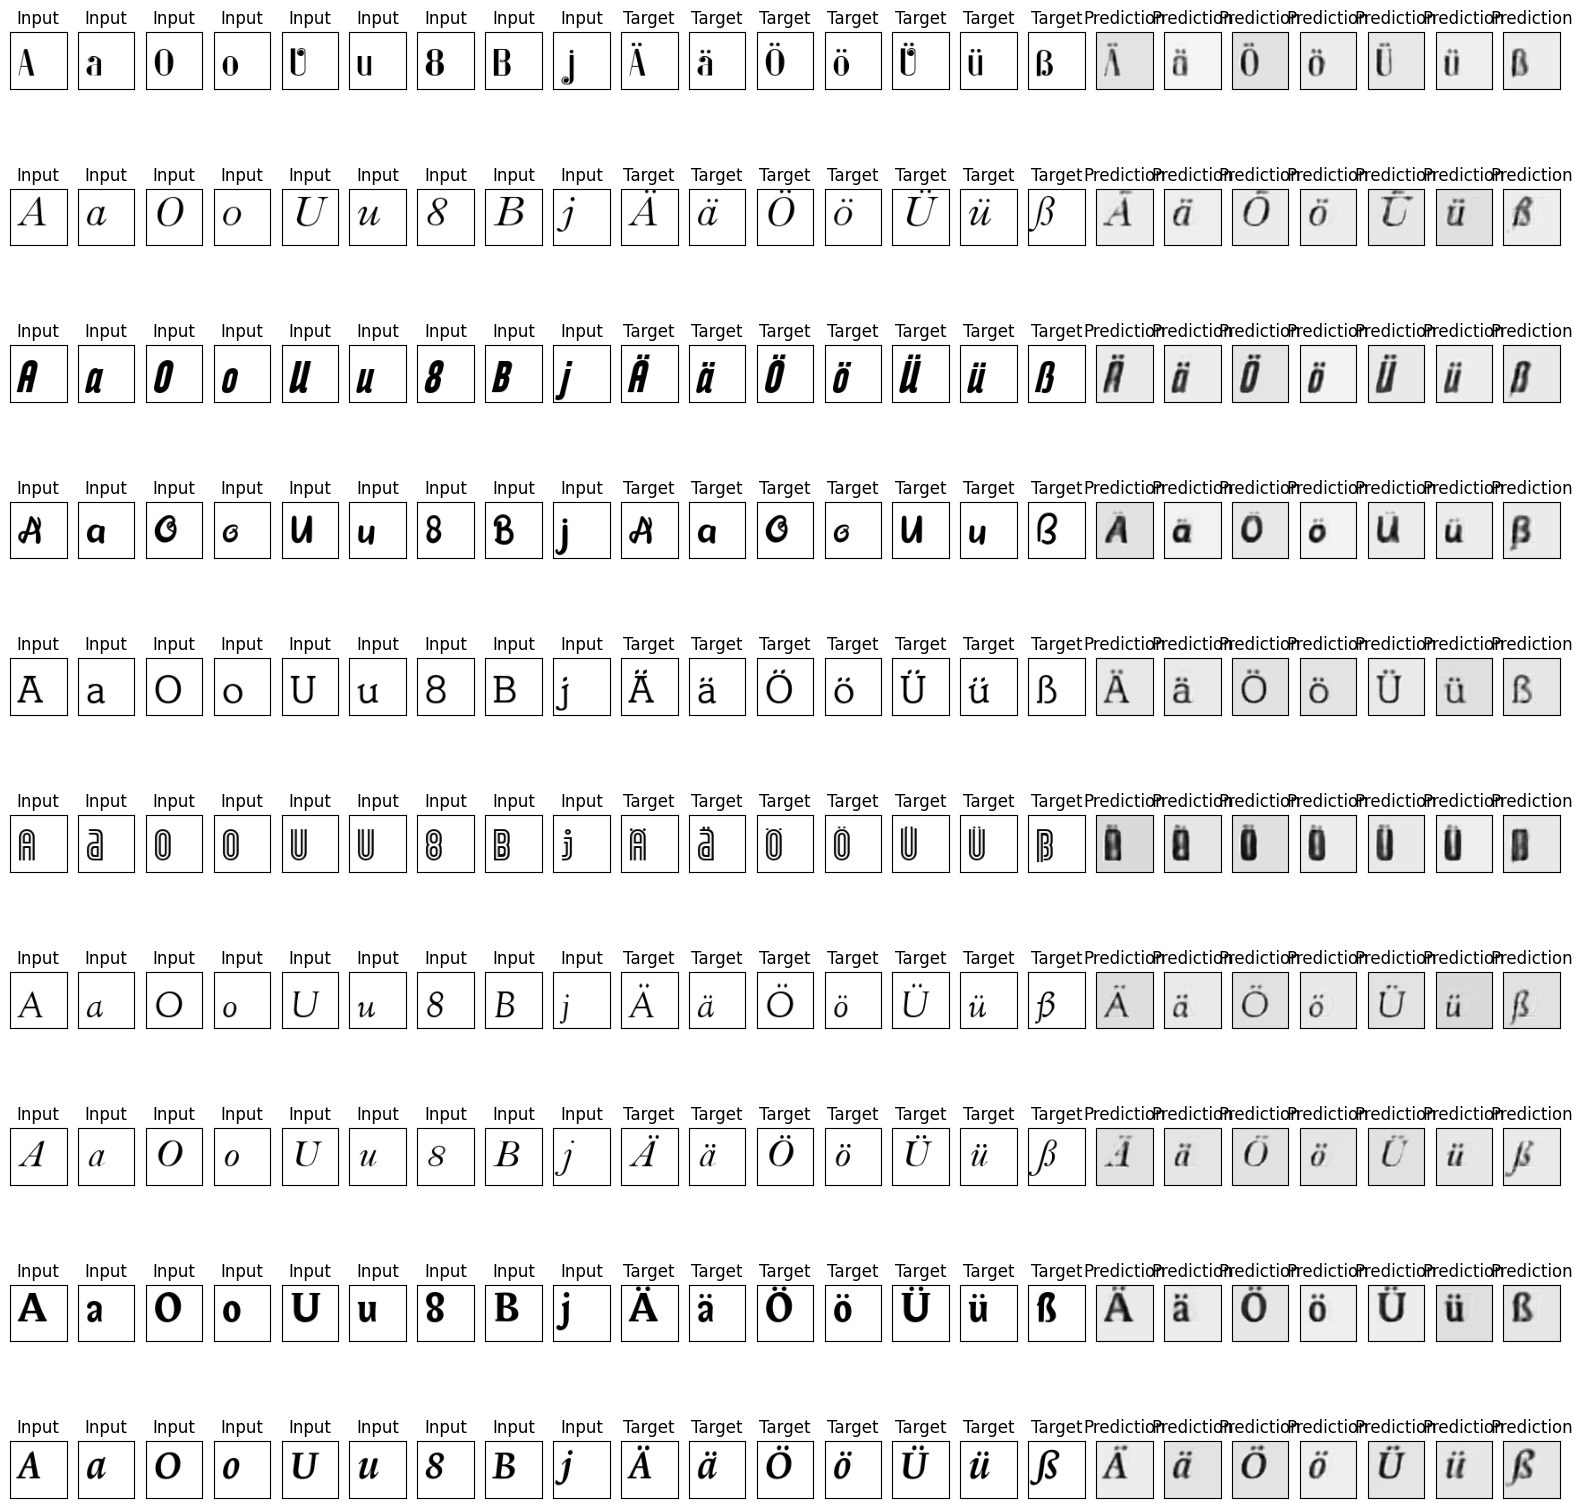

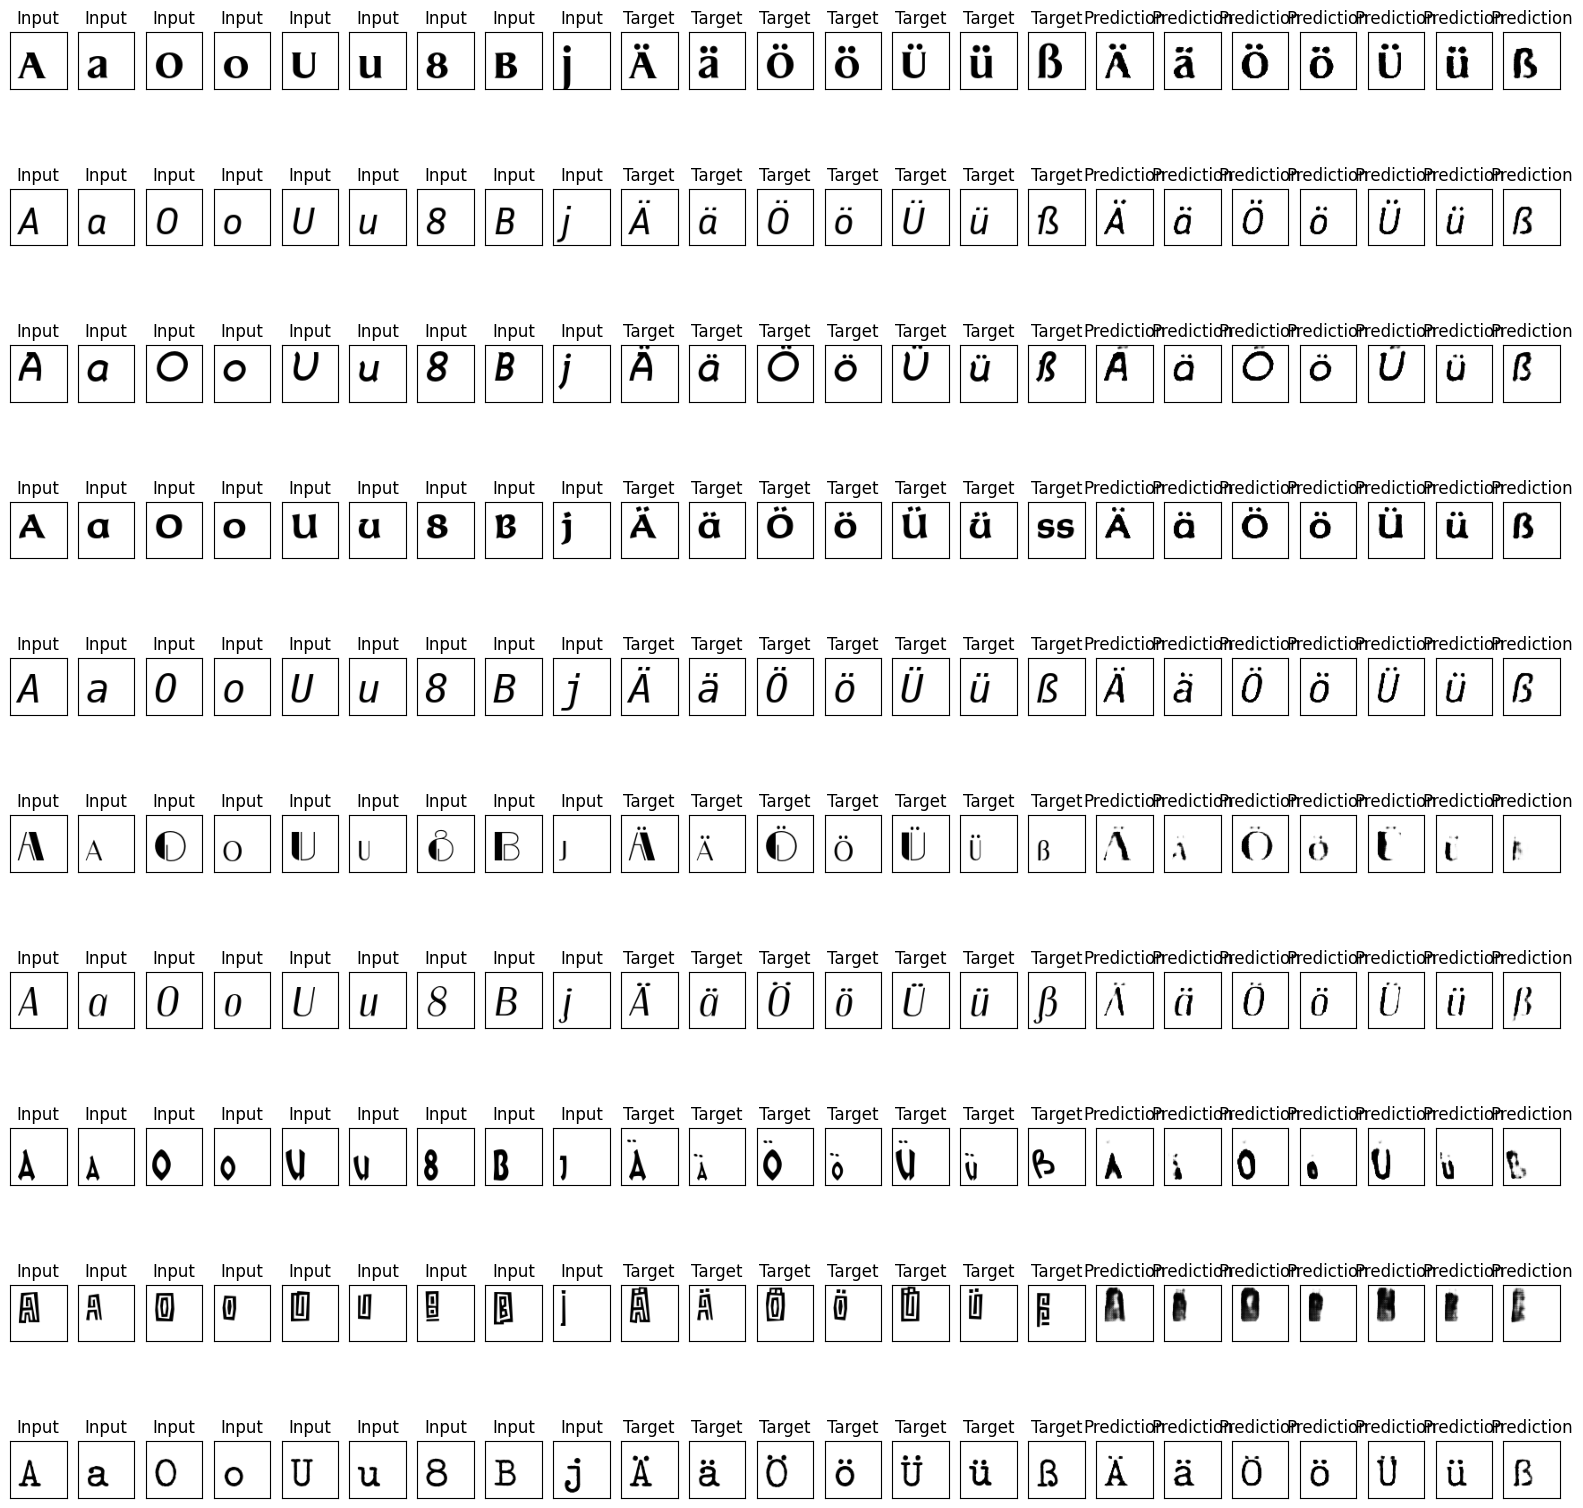

In [99]:
render_predictions(model, dataset_train, num_examples=10, figsize=(20, 20))
render_predictions(model, dataset_train, num_examples=10, figsize=(20, 20), black_white=True)